In [2]:
import struct, os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
DATA_DIR = 'mnist_data'

# Helpers to read IDX files
def load_idx_images(filepath):
    with open(filepath, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        data = np.fromfile(f, dtype=np.uint8)
    return data.reshape(num, rows, cols)

def load_idx_labels(filepath):
    with open(filepath, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

# Load raw data
raw_train = load_idx_images(os.path.join(DATA_DIR,'train-images.idx3-ubyte'))
raw_test  = load_idx_images(os.path.join(DATA_DIR,'t10k-images.idx3-ubyte'))
y_train   = load_idx_labels(os.path.join(DATA_DIR,'train-labels.idx1-ubyte'))
y_test    = load_idx_labels(os.path.join(DATA_DIR,'t10k-labels.idx1-ubyte'))

# Build two versions of X: [0,1] for VAE, and normalized for CNN 
X_train_raw = torch.from_numpy(raw_train.astype(np.float32)/255.0).unsqueeze(1)
X_test_raw  = torch.from_numpy(raw_test.astype(np.float32)/255.0).unsqueeze(1)

mean, std = 0.1307, 0.3081
X_train_norm = ((raw_train.astype(np.float32)/255.0 - mean) / std)
X_test_norm  = ((raw_test.astype(np.float32)/255.0 - mean) / std)
X_train_norm = torch.from_numpy(X_train_norm).unsqueeze(1)
X_test_norm  = torch.from_numpy(X_test_norm).unsqueeze(1)

y_train = torch.from_numpy(y_train).long()
y_test  = torch.from_numpy(y_test).long()

batch_size = 128

# DataLoaders
train_loader_raw = DataLoader(TensorDataset(X_train_raw, y_train),
                              batch_size=batch_size, shuffle=True)
test_loader_raw  = DataLoader(TensorDataset(X_test_raw,  y_test),
                              batch_size=batch_size, shuffle=False)

train_loader_norm = DataLoader(TensorDataset(X_train_norm, y_train),
                               batch_size=batch_size, shuffle=True)
test_loader_norm  = DataLoader(TensorDataset(X_test_norm,  y_test),
                               batch_size=batch_size, shuffle=False)


Using device: cuda


CNN Digit Classifier

[CNN] Epoch 1/10 → loss 0.1673
[CNN] Epoch 2/10 → loss 0.0487
[CNN] Epoch 3/10 → loss 0.0337
[CNN] Epoch 4/10 → loss 0.0230
[CNN] Epoch 5/10 → loss 0.0178
[CNN] Epoch 6/10 → loss 0.0141
[CNN] Epoch 7/10 → loss 0.0121
[CNN] Epoch 8/10 → loss 0.0094
[CNN] Epoch 9/10 → loss 0.0088
[CNN] Epoch 10/10 → loss 0.0087


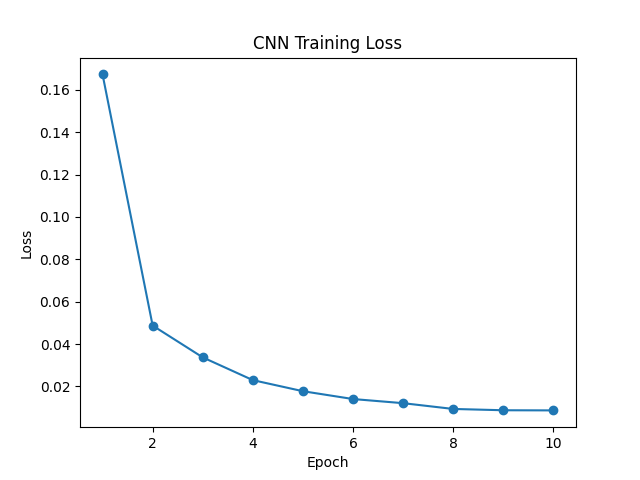

In [3]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,32,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7,128), nn.ReLU(),
            nn.Linear(128,10)
        )
    def forward(self,x):
        return self.classifier(self.features(x))

clf = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
opt_clf = optim.Adam(clf.parameters(), lr=1e-3)

epochs = 10
losses = []
for ep in range(1, epochs+1):
    clf.train()
    running = 0
    for x, y in train_loader_norm:
        x, y = x.to(device), y.to(device)
        opt_clf.zero_grad()
        loss = criterion(clf(x), y)
        loss.backward()
        opt_clf.step()
        running += loss.item()*x.size(0)
    epoch_loss = running/len(train_loader_norm.dataset)
    losses.append(epoch_loss)
    print(f"[CNN] Epoch {ep}/{epochs} → loss {epoch_loss:.4f}")

# plot
plt.plot(range(1,epochs+1), losses, marker='o')
plt.title("CNN Training Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.show()


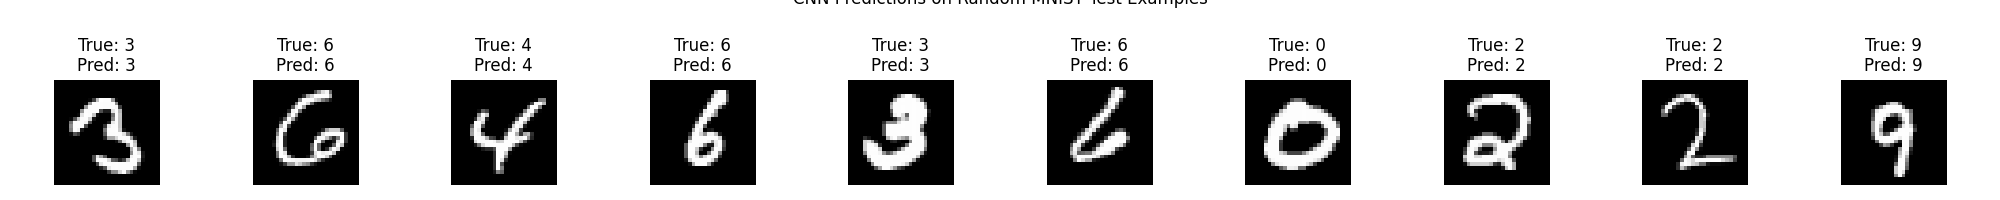

In [ ]:
import random
import matplotlib.pyplot as plt

# Make sure the classifier is in eval mode
clf.eval()

# Number of examples to show
n_examples = 10

# Randomly pick indices from the test set
indices = random.sample(range(len(X_test_norm)), n_examples)

# Prepare a row of subplots
fig, axes = plt.subplots(1, n_examples, figsize=(n_examples*2, 2))
for ax, idx in zip(axes, indices):
    # raw image for display (in [0,1])
    img_raw = X_test_raw[idx].squeeze(0)       # torch tensor shape (28,28)
    # normalized image for input (batch dim + channel dim)
    img_norm = X_test_norm[idx].unsqueeze(0).to(device)  # shape (1,1,28,28)
    true_lbl = y_test[idx].item()
    
    # Run through the CNN and get the predicted class
    with torch.no_grad():
        logits = clf(img_norm)
        pred_lbl = logits.argmax(dim=1).item()
    
    # Plot
    ax.imshow(img_raw.cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    ax.set_title(f"True: {true_lbl}\nPred: {pred_lbl}")
    ax.axis('off')

plt.suptitle("CNN Predictions on Random MNIST Test Examples", y=1.05)
plt.tight_layout()
plt.show()

# Save the classifier model
torch.save(clf.state_dict(), 'models/cnn_classifier.pt')


# VAE (Attempting to Create New Numbers)

[VAE] Epoch 1/20 → loss 190.7118
[VAE] Epoch 2/20 → loss 167.5524
[VAE] Epoch 3/20 → loss 163.1443
[VAE] Epoch 4/20 → loss 160.5229
[VAE] Epoch 5/20 → loss 158.8127
[VAE] Epoch 6/20 → loss 157.6436
[VAE] Epoch 7/20 → loss 156.6024
[VAE] Epoch 8/20 → loss 155.7464
[VAE] Epoch 9/20 → loss 155.0339
[VAE] Epoch 10/20 → loss 154.3914
[VAE] Epoch 11/20 → loss 153.8598
[VAE] Epoch 12/20 → loss 153.3152
[VAE] Epoch 13/20 → loss 152.8136
[VAE] Epoch 14/20 → loss 152.3534
[VAE] Epoch 15/20 → loss 152.0299
[VAE] Epoch 16/20 → loss 151.6518
[VAE] Epoch 17/20 → loss 151.3208
[VAE] Epoch 18/20 → loss 151.0200
[VAE] Epoch 19/20 → loss 150.6965
[VAE] Epoch 20/20 → loss 150.4162


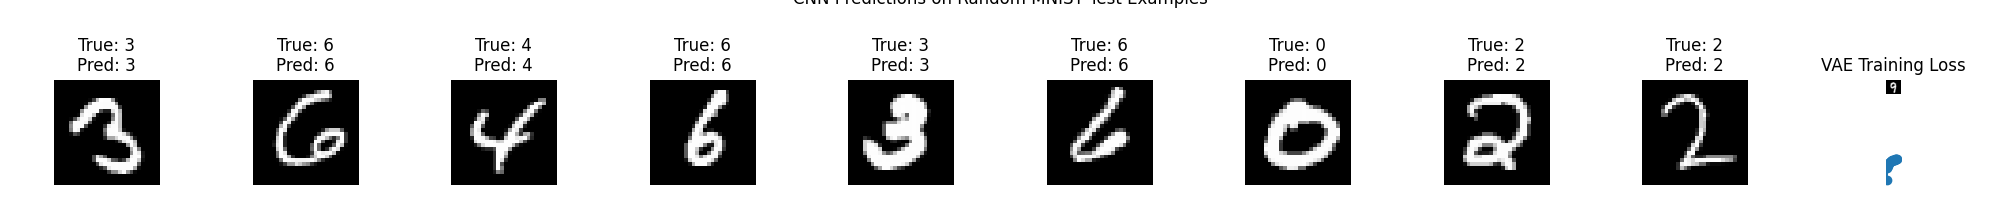

In [ ]:
class VAE(nn.Module):
    def __init__(self, zdim=2):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28,400), nn.ReLU()
        )
        self.mu     = nn.Linear(400, zdim)
        self.logvar = nn.Linear(400, zdim)
        self.dec = nn.Sequential(
            nn.Linear(zdim,400), nn.ReLU(),
            nn.Linear(400,28*28), nn.Sigmoid()
        )
    def encode(self, x):
        h = self.enc(x)
        return self.mu(h), self.logvar(h)
    def reparam(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        return mu + torch.randn_like(std)*std
    def decode(self, z):
        return self.dec(z)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon, x, mu, logvar):
    # recon ∈[0,1], x ∈[0,1]
    BCE = nn.functional.binary_cross_entropy(
        recon, x.view(-1,28*28), reduction='sum'
    )
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (BCE + KLD)/x.size(0)

vae = VAE(zdim=2).to(device)
opt_vae = optim.Adam(vae.parameters(), lr=1e-3)

epochs = 20
v_losses = []
for ep in range(1, epochs+1):
    vae.train()
    total = 0
    for x, _ in train_loader_raw:
        x = x.to(device)
        opt_vae.zero_grad()
        recon, mu, logvar = vae(x)
        loss = vae_loss(recon, x, mu, logvar)
        loss.backward()
        opt_vae.step()
        total += loss.item()
    avg = total/len(train_loader_raw)
    v_losses.append(avg)
    print(f"[VAE] Epoch {ep}/{epochs} → loss {avg:.4f}")

# plot
plt.plot(range(1,epochs+1), v_losses, marker='o')
plt.title("VAE Training Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.show()

# Save the model
torch.save(vae.state_dict(), 'models/vae.pt')

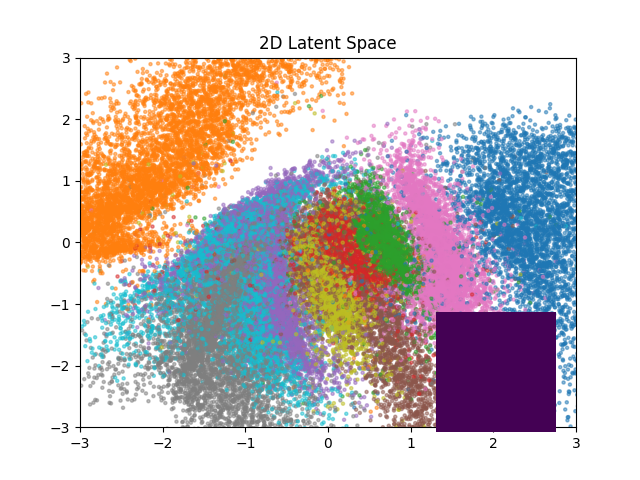

In [6]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

# Scatter encoded train points
vae.eval()
all_mu, all_lbl = [], []
with torch.no_grad():
    for imgs, lbls in train_loader_raw:
        imgs = imgs.to(device)
        mu, _ = vae.encode(imgs.view(-1,28*28))
        all_mu.append(mu.cpu().numpy()); all_lbl.append(lbls.numpy())
all_mu  = np.vstack(all_mu)
all_lbl = np.concatenate(all_lbl)

# Plot + interactive decode
fig, ax = plt.subplots()
sc = ax.scatter(all_mu[:,0], all_mu[:,1], c=all_lbl, cmap='tab10', s=5, alpha=0.5)
ax.set_xlim(-3,3); ax.set_ylim(-3,3)
ax.set_title("2D Latent Space")

# Inset image for decoded digit
img_ax = fig.add_axes([0.65, 0.1, 0.25, 0.25])
disp = img_ax.imshow(np.zeros((28,28)), interpolation='nearest', vmin=0, vmax=1)
img_ax.axis('off')

# Function to update the inset image based on mouse movement
def on_move(event):
    if event.inaxes == ax and event.xdata is not None:
        z = torch.tensor([[event.xdata, event.ydata]], device=device, dtype=torch.float)
        with torch.no_grad():
            recon = vae.dec(z).cpu().view(28,28).numpy()
        disp.set_data(recon)
        fig.canvas.draw_idle()

fig.canvas.mpl_connect('motion_notify_event', on_move)
plt.show()
